### Lesson 2 Assignment: Bad vs. Good Connections
### Lawrence Huang
#### Instructions:

Using the Intrusion Detection csv file create a new notebook and perform each of the following tasks and answer the related questions:

1. Read data
2. Build a classifier
3. Determine your model accuracy
4. Modify data by handling class imbalance
5. Use the same model on updated data
6. What is the accuracy?
7. Describe your findings

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE 

Using TensorFlow backend.


##### 1. Read data and preprocessing

In [2]:
# Load data: Intrusion Detection
filename = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Intrusion%20Detection.csv'
df = pd.read_csv(filename)
# preview data
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(97308, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [3]:
# all columns except the following are of int/float type: protocol_type, service, flag
print('data types:')
print(df.dtypes)
# find number of NANs/missing values
print('\nnumber of nan values: {}'.format(df.isna().sum().sum()))

data types:
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_ra

In [4]:
# no obvious missing values in categorical variables 
print(df['protocol_type'].value_counts())
print('\n')
print(df['service'].value_counts())
print('\n')
print(df['flag'].value_counts())

tcp     76843
udp     19177
icmp     1288
Name: protocol_type, dtype: int64


http        61886
smtp         9598
private      7366
domain_u     5862
other        5632
ftp_data     3806
urp_i         537
finger        468
eco_i         389
ntp_u         380
ftp           374
ecr_i         345
telnet        240
auth          220
pop_3          79
time           52
IRC            42
urh_i          14
X11             9
domain          3
tim_i           2
red_i           1
ssh             1
shell           1
tftp_u          1
Name: service, dtype: int64


SF      91738
REJ      5341
RSTO       68
S1         54
S0         51
RSTR       31
S2         17
S3          7
OTH         1
Name: flag, dtype: int64


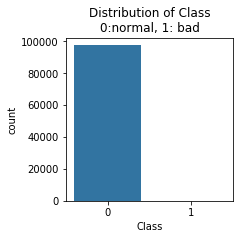

In [5]:
# plot distribution of the target variable Class
# confirmed that classes are highly imbalanced
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x='Class', data=df, ax=ax)
plt.title('Distribution of Class\n0:normal, 1: bad')
plt.show()

In [6]:
# prepare for one-hot encoding
# find categorical variables of object dtype
cat_cols = df.select_dtypes(include=["object"]).columns.to_list()

# Find additional potential categorical variables with 5 or less unique values
cat_cols.extend(df.columns[(df.nunique()>2) & (df.nunique()<=5) & (df.dtypes!='object')].to_list())

print('variables to one-hot encode: {}'.format(cat_cols))

variables to one-hot encode: ['protocol_type', 'service', 'flag', 'num_failed_logins', 'su_attempted']


In [7]:
# One-hot encode categorical data, represent all categories except for one to avoid a linearly dependent data set
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [8]:
# find variables with a single value; non-unique variables are not useful for modeling
cols_to_drop = df.columns[df.nunique()<2].to_list()
print('variables to drop: {}'.format(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True)

variables to drop: ['wrong_fragment', 'num_outbound_cmds', 'is_host_login']


In [9]:
# view dataframe shape after preprocessing
print('dataset shape:{}'.format(df.shape))
df.head()

dataset shape:(97308, 74)


,duration,src_bytes,dst_bytes,land,urgent,hot,logged_in,num_compromised,root_shell,num_root,...,flag_S1,flag_S2,flag_S3,flag_SF,num_failed_logins_1,num_failed_logins_2,num_failed_logins_3,num_failed_logins_4,su_attempted_1,su_attempted_2
0,0,181,5450,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,239,486,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,235,1337,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,219,1337,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,217,2032,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [10]:
# train/test split
# stratify to ensure minority class representation in both sets
y = df['Class'] # label
X = df.loc[:, ~df.columns.isin(['Class'])] # features, use all but the target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('features: {}'.format(X.columns.values))
print('\n# features: {}'.format(len(X.columns.values)))

features: ['duration' 'src_bytes' 'dst_bytes' 'land' 'urgent' 'hot' 'logged_in'
 'num_compromised' 'root_shell' 'num_root' 'num_file_creations'
 'num_shells' 'num_access_files' 'is_guest_login' 'count' 'srv_count'
 'serror_rate' 'srv_serror_rate' 'rerror_rate' 'srv_rerror_rate'
 'same_srv_rate' 'diff_srv_rate' 'srv_diff_host_rate' 'dst_host_count'
 'dst_host_srv_count' 'dst_host_same_srv_rate' 'dst_host_diff_srv_rate'
 'dst_host_same_src_port_rate' 'dst_host_srv_diff_host_rate'
 'dst_host_serror_rate' 'dst_host_srv_serror_rate' 'dst_host_rerror_rate'
 'dst_host_srv_rerror_rate' 'protocol_type_tcp' 'protocol_type_udp'
 'service_X11' 'service_auth' 'service_domain' 'service_domain_u'
 'service_eco_i' 'service_ecr_i' 'service_finger' 'service_ftp'
 'service_ftp_data' 'service_http' 'service_ntp_u' 'service_other'
 'service_pop_3' 'service_private' 'service_red_i' 'service_shell'
 'service_smtp' 'service_ssh' 'service_telnet' 'service_tftp_u'
 'service_tim_i' 'service_time' 'service_urh_i'

In [11]:
# standardize numeric columns (z-score)
# find continuous variables with greater than 2 unique values (non-binary)
num_cols = X_train.columns[(X_train.nunique()>2)].to_list()
scaler = StandardScaler().fit(X_train[num_cols])
X_train = X_train.copy()
X_test = X_test.copy()
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

##### 2. Build a classifier

In [12]:
# logistic regression
classifier = LogisticRegression(penalty='l1', solver='liblinear', random_state=8) 
print(classifier)
classifier.fit(X_train, y_train) 
print('\nsparsity with L1 penalty: {:.2f}%'.format(np.mean(classifier.coef_==0)*100))

# 10-fold cross validation with StratifiedKFold
# metric = recall on class 1 (minority class)
skf = StratifiedKFold(n_splits=10, random_state=6)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=skf, scoring='recall') 
print('\nmean cross-validated recall (class 1): {}'.format(np.mean(cv_scores)))

# prediction
y_prob = classifier.predict_proba(X_test) # probability estimates
y_pred = classifier.predict(X_test) # predict class labels

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=8, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

sparsity with L1 penalty: 71.23%

mean cross-validated recall (class 1): 0.6666666666666666


##### 3. Determine your model accuracy

In [13]:
# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix (0.5 probability threshold):')
print(confusion_matrix(y_test, y_pred)) 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred))


Confusion Matrix (0.5 probability threshold):
[[19455     1]
 [    2     4]]

TP, TN, FP, FN: 4 , 19455 , 1 , 2

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19456
           1       0.80      0.67      0.73         6

    accuracy                           1.00     19462
   macro avg       0.90      0.83      0.86     19462
weighted avg       1.00      1.00      1.00     19462



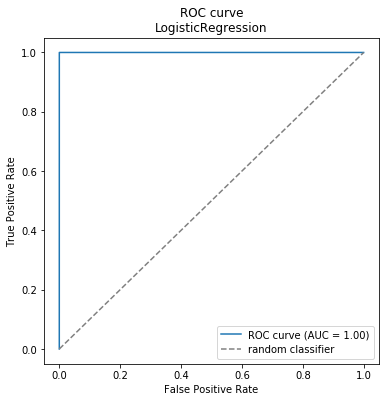

In [14]:
# Calculate the ROC curve and AUC
# get false positive rate, true posisive rate, probability thresholds
fpr, tpr, thrs = roc_curve(y_test, y_prob[:,1])
# get area under the curve
area_under_curve = auc(fpr, tpr)

# plot ROC curve with AUC score
plt.figure(figsize=[6,6])
plt.title('ROC curve\n'+type(classifier).__name__)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1], c='gray', linestyle='--', label='random classifier')
plt.legend(loc="lower right")
plt.show()

#### Results/Model accuracy: <a name="1"></a>

In this dataset the classes are imbalanced. The model would attempt to reduce global quantities such as error rate (maximizing overall accuracy) and not take into consideration the data distribution. As a result, the model may be biased toward the majority class, where the samples from the majority class are well-classified and samples from the minority class tend to be misclassified. Therefore, accuracy is not a good metric. 

For detecting bad connections (minority class) an appropriate metric would be recall. That is, we would want to detect all the bad connections (trade off: false positives). Alternatively, the f1 score of the bad connections, also taking into account precision, could be used.

Here, for detecting bad connections the model precision was 0.8, recall was 0.67, and f1-score was 0.73. To focus on the effect of data resampling, the probability threshold for classification was not modified from 0.5.

As shown here, ROC curves could sometimes be misleading for imbalanced data. The ROC curve and AUC ROC here indicates an essentially perfect classifier, even though the model misclassified a considerable fraction (here, 2 out of 6) of the minority class.

[Bottom of notebook](#bot)

##### 4. Modify data by handling class imbalance
SMOTE was used to oversample the minority class. By oversampling only on the training data, none of the information in the test data was being used to create synthetic observations. Therefore, no information will bleed from training to testing.

Oversampling on both the training and test set may result in overfitting. Also, evaluation metrics on the oversampled test set will be less informative, as the oversampled test data will not be representative of unseen, real-world data.

Importantly, the number of minority class in the test set was greater than zero.

In [15]:
# use SMOTE to create synthetic observations of the minority class for the training set
sm = SMOTE(random_state=1) # sampling strategy = resample all classes but the majority class
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(data=X_train_res, columns=X_train.columns)
y_train_res = pd.Series(y_train_res)

print('target value counts before SMOTE:')
print(y_train.value_counts())
print('target value counts after SMOTE:')
print(y_train_res.value_counts())

target value counts before SMOTE:
0    77822
1       24
Name: Class, dtype: int64
target value counts after SMOTE:
1    77822
0    77822
dtype: int64


##### 5. Use the same model on updated data

In [16]:
# logistic regression, trained using balanced training set
classifier = LogisticRegression(penalty='l1', solver='liblinear', random_state=8) 
print(classifier)
classifier.fit(X_train_res, y_train_res)
print('\nsparsity with L1 penalty: {:.2f}%'.format(np.mean(classifier.coef_==0)*100))

# 10-fold cross validation with StratifiedKFold
# metric = recall on class 1 (minority class)
skf = StratifiedKFold(n_splits=10, random_state=6)
cv_scores_res = cross_val_score(classifier, X_train_res, y_train_res, cv=skf, scoring='recall') 
print('\nmean cross-validated recall (class 1): {}'.format(np.mean(cv_scores_res)))

# prediction
y_prob_res = classifier.predict_proba(X_test) # probability estimates
y_pred_res = classifier.predict(X_test) # predict class labels

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=8, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

sparsity with L1 penalty: 52.05%

mean cross-validated recall (class 1): 1.0


##### 6. What is the accuracy?

In [17]:
# evaluate model using confusion matrix-derived metrics
print ('\nConfusion Matrix (0.5 probability threshold):')
print(confusion_matrix(y_test, y_pred_res))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_res).ravel()
print ('\nTP, TN, FP, FN:', tp, ',', tn, ',', fp, ',', fn)
print ('\nClassification report:')
print(classification_report(y_test, y_pred_res))


Confusion Matrix (0.5 probability threshold):
[[19448     8]
 [    0     6]]

TP, TN, FP, FN: 6 , 19448 , 8 , 0

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19456
           1       0.43      1.00      0.60         6

    accuracy                           1.00     19462
   macro avg       0.71      1.00      0.80     19462
weighted avg       1.00      1.00      1.00     19462



#### Results/Model accuracy: <a name="2"></a>

SMOTE was used to oversample the minority class on the training set. The retrained model was no longer biased toward any classes (but there may be some class mixture, due to the very sparse nature of the minority class with respect to the majority class). Using this retrained model on the original test set, recall = 1 and all bad connections were correctly classified, with no false negatives. However, this was at the expense of false positives, resulting in a lower precision (0.43) and f1-score (0.6).

[Bottom of notebook](#bot)

##### 7. Describe your findings<a name="bot"></a>
#### Please see discussion of results/model accuracy after each model/data prepration strategy:
[Imbalanced classes, no oversampling](#1)<br>
[Balanced by oversampling (creating synthetic samples) of the minority class in the training set](#2)<br>